In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils
import torch.utils.data
import torch.optim as optim

from copy import deepcopy

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [2]:
# Make sure that we are utilizing a DL accelerator
DEVICE_CPU = torch.device("cpu")
DEVICE_GPU = torch.device("cuda")

device = DEVICE_GPU if torch.cuda.is_available() else DEVICE_CPU
print(device)

cuda


Load datasets.

Files already downloaded and verified


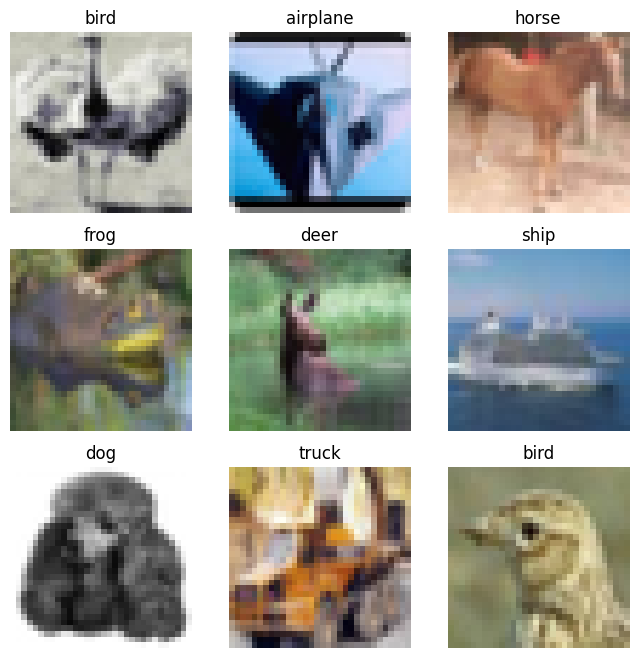

In [3]:
# Load CIFAR-10 dataset
train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=ToTensor())
train_set, valid_set = torch.utils.data.random_split(train_set, [0.9, 0.1])

labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

# Plot some images with labels
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze(), cmap="gray")
plt.show()

Define models.

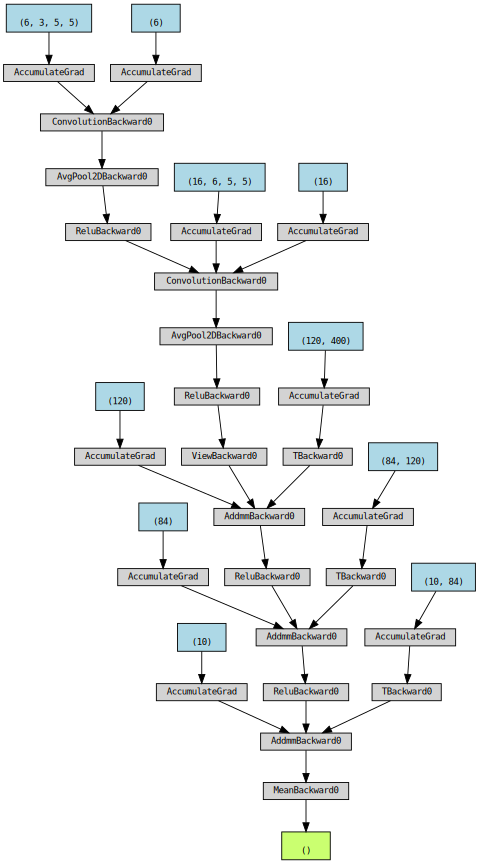

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor


# Define model
# TODO: Check how the initialization is handled in Pytorch
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5), stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1)

        self.avgpool1 = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.avgpool2 = nn.AvgPool2d(kernel_size=(2, 2), stride=2)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=5 * 5 * 16, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, X):
        X = F.relu(self.avgpool1(self.conv1(X)))
        X = F.relu(self.avgpool2(self.conv2(X)))

        X = torch.flatten(X, 1)
        X = self.mlp(X)
        return X


from torchviz import make_dot

X, label = train_set[0]
X = X.unsqueeze(0)
y = LeNet()(X)
make_dot(y.mean())

In [5]:
print(sum(p.numel() for p in LeNet().parameters() if p.requires_grad))

62006


In [6]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        nn.init.constant_(m.bias, 0)


model = LeNet()
model.apply(init_weights)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (avgpool2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (mlp): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

Define train loop.

In [7]:
from tqdm import trange


def train_model(
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion,
    dataloaders: DataLoader,
    n_epochs: int,
    device=DEVICE_GPU,
):
    model.to(device)

    best_acc, best_model_wts = 0.0, deepcopy(model.state_dict())

    for _ in (pbar := trange(1, n_epochs + 1)):
        for phase in ["train", "valid"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            # deep copy the model
            if phase == "valid" and epoch_acc > best_acc:
                best_acc, best_model_wts = epoch_acc, deepcopy(model.state_dict())

        pbar.set_description(f"Best valid acc {best_acc*100:.2f}%")

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model


@torch.no_grad()
def eval_model(model: nn.Module, dataloader: DataLoader, device=DEVICE_GPU):
    model.to(device)
    model.eval()

    corrects = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        corrects += torch.sum(preds == labels.data)

    test_acc = corrects / len(dataloader.dataset)
    # print(f"Test Acc: {test_acc:.4f}")
    return test_acc

Train base model.

In [8]:
# batch_size = 32
# # Define data loaders
# dataloaders = {
#     "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
#     "valid": DataLoader(valid_set, batch_size=batch_size, shuffle=True),
# }

# # Define model, loss function and optimizer (with defaul params)
# model = LeNet()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters())

# # Train model
# train_model(model, optimizer, criterion, dataloaders, n_epochs=100)

# # Evaluate model performance
# test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=ToTensor())
# test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
# eval_model(model, test_dataloader)

Define complex model.

In [9]:
class ConvGroup(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, pool: bool = False):
        super().__init__()

        layers = [
            nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),
        ]

        if pool:
            layers.append(nn.MaxPool2d(kernel_size=2))

        self.conv_group = nn.Sequential(*layers)

    def forward(self, X: Tensor):
        return self.conv_group(X)


class ResNet(nn.Module):
    def __init__(self, p: float = 0.5):
        super().__init__()

        self.conv_group1 = ConvGroup(3, 64)
        self.conv_group2 = ConvGroup(64, 128, pool=True)
        self.conv_group3 = ConvGroup(128, 256, pool=True)
        self.conv_group4 = ConvGroup(256, 256, pool=True)

        self.res1 = nn.Sequential(ConvGroup(128, 128), ConvGroup(128, 128))
        self.res2 = nn.Sequential(ConvGroup(256, 256), ConvGroup(256, 256))

        self.dropout = nn.Dropout(p)

        self.clf = nn.Sequential(
            nn.MaxPool2d(kernel_size=4),
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=10),
        )

    def forward(self, X: Tensor):
        y = X

        y = self.conv_group1(y)
        y = self.conv_group2(y)
        y = y + self.res1(y)

        y = self.conv_group3(y)
        y = self.conv_group4(y)
        y = y + self.res2(y)

        y = self.dropout(y)

        y = self.clf(y)

        return y


def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        nn.init.constant_(m.bias, 0)

In [10]:
batch_size = 64
# Define data loaders
dataloaders = {
    "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
    "valid": DataLoader(valid_set, batch_size=batch_size, shuffle=True),
}

# Define model, loss function and optimizer (with defaul params)
model = ResNet()
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=0.045)

# Train model
train_model(model, optimizer, criterion, dataloaders, n_epochs=50)

# Evaluate model performance
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=ToTensor())
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
eval_model(model, test_dataloader)

Best valid acc 50.04%:   2%|▏         | 1/50 [00:29<23:53, 29.25s/it]


KeyboardInterrupt: 